In [2]:
# Any number of GCN and LSTM layers can be added
# Dropout and dense layers decrease the over-fitting problem
# TODO: What can we change?
# Method here is used for univariate (single-value) scalars
# https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html

In [3]:
pip install stellargraph

You should consider upgrading via the '/Users/deneme/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# All necessary imports here
import os
import sys
import urllib.request

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

import stellargraph as sg

from stellargraph.layer import GCN_LSTM

import time

## Preparing Datasets

In [5]:
#read pollutant values
# A N by T feature matrix, which describes the (f_1, .., f_T) speed records over T timesteps for the N sensors.
dfPollutant = pd.read_excel(
     "PM10.xlsx",
     engine='openpyxl',
     parse_dates=True,
     thousands='.'
)

#remove index column
dfPollutant = dfPollutant.iloc[: , 1:] 
dfPollutant = dfPollutant.T
print (dfPollutant)
#dataset info
num_nodes, time_len = dfPollutant.shape
print("No. of sensors:", num_nodes, "\nNo of timesteps:", time_len)

                 0          1          2          3          4          5      \
Aksaray      42.200001  41.799999  44.200001  41.700001  49.700001  48.400002   
Besiktas     37.599998  42.000000  39.000000  37.599998  48.500000  47.200001   
Buyukada      9.600000  12.000000  12.800000  13.800000  16.400000  19.400000   
Catladıkapı  24.100000  27.299999  40.200001  41.599998  40.900002  42.700001   
Esenler      28.100000  34.200001  33.099998  33.799999  36.000000  42.200001   
Kadıkoy      21.400000  24.200001  18.799999  18.000000  19.500000  23.299999   
Kandilli      6.800000   5.300000  11.500000  13.400000  18.000000  21.000000   
Kartal       46.599998  39.700001  49.299999  47.099998  48.799999  60.900002   
Mecidiyekoy  73.320000  76.489998  77.769997  82.419998  82.059998  85.529999   
Umraniye     34.200001  38.200001  45.400002  43.599998  47.000000  47.000000   

                 6          7          8          9      ...      19990  \
Aksaray      51.400002  45.599998

In [6]:
# A N by N adjacency matrix, which describes the distance relationship between the N sensors,
dfSensor = pd.read_excel(
     "sensor_dist_adj.xlsx",
     engine='openpyxl',
     parse_dates=True,
     thousands='.',
     header=None
)

print (dfSensor)

          0         1         2         3         4         5         6  \
0  1.000000  0.722460  0.347210  0.635260  0.395078  0.772162  0.814077   
1  0.722460  1.000000  0.183991  0.788390  0.649487  0.759052  0.855588   
2  0.347210  0.183991  1.000000  0.301421  0.042394  0.423118  0.187686   
3  0.635260  0.788390  0.301421  1.000000  0.719700  0.828519  0.672038   
4  0.395078  0.649487  0.042394  0.719700  1.000000  0.550986  0.505715   
5  0.772162  0.759052  0.423118  0.828519  0.550986  1.000000  0.720448   
6  0.814077  0.855588  0.187686  0.672038  0.505715  0.720448  1.000000   
7  0.510274  0.273015  0.710303  0.314092  0.033963  0.477367  0.326578   
8  0.661599  0.932323  0.118981  0.753599  0.677663  0.695497  0.817854   
9  0.817527  0.541053  0.381116  0.466508  0.214574  0.624620  0.650054   

          7         8         9  
0  0.510274  0.661599  0.817527  
1  0.273015  0.932323  0.541053  
2  0.710303  0.118981  0.381116  
3  0.314092  0.753599  0.466508  
4  0

In [8]:
# Train - Test split
def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:, :train_size])
    test_data = np.array(data.iloc[:, train_size:])
    return train_data, test_data

# Scaling
def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled

In [9]:
train_rate = 0.8
train_data, test_data = train_test_split(dfPollutant, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)
train_scaled, test_scaled = scale_data(train_data, test_data)

Train data:  (10, 16000)
Test data:  (10, 4000)


In [12]:
train_scaled

array([[0.0078029 , 0.00772841, 0.00817535, ..., 0.00256993, 0.00303549,
        0.002961  ],
       [0.00694625, 0.00776565, 0.00720697, ..., 0.00322172, 0.00217885,
        0.001974  ],
       [0.00173191, 0.00217885, 0.00232783, ..., 0.00113598, 0.00160155,
        0.00113598],
       ...,
       [0.00862229, 0.00733733, 0.00912511, ..., 0.00141532, 0.00173191,
        0.00135945],
       [0.01359827, 0.01418861, 0.01442698, ..., 0.00445268, 0.00435398,
        0.00368915],
       [0.00631308, 0.00705799, 0.00839882, ..., 0.00206712, 0.00199263,
        0.0018064 ]])

In [13]:
# This value represents the past feature window size
seq_len = 10
# This value represents how far ahead we want to predict
pre_len = 12
# Data for LSTM is prepared using the Sliding Window approach
# Sliding windows are applied for each sensor
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [14]:
# We expect to see features of seq_len window size for each sensor 
# and labels as the pre_len ahead output
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(15979, 10, 10)
(15979, 10)
(3979, 10, 10)
(3979, 10)


## Creating the GCN LSTM Model

In [15]:
## GCN and LSTM Model
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=dfSensor,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
)

/Users/deneme/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  


In [16]:
x_input, x_output = gcn_lstm.in_out_tensors()

In [17]:
model = Model(inputs=x_input, outputs=x_output)

In [18]:
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

In [19]:
start_time = time.time()

history = model.fit(
    trainX,
    trainY,
    epochs=100,
    batch_size=60,
    shuffle=True,
    verbose=0,
    validation_data=(testX, testY),
)

print("Execution time: %s seconds" % (time.time() - start_time))

Execution time: 1005.234628200531 seconds


In [20]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 10)]          0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 10, 10, 1)]       0         
_________________________________________________________________
reshape (Reshape)            (None, 10, 10)            0         
_________________________________________________________________
fixed_adjacency_graph_convol (None, 10, 16)            270       
_________________________________________________________________
fixed_adjacency_graph_convol (None, 10, 10)            270       
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 10, 1)         0         
_________________________________________________________________
permute (Permute)            (None, 10, 10, 1)        

In [21]:
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
)

Train loss:  0.0025903156492859125 
Test loss: 0.0025824897456914186


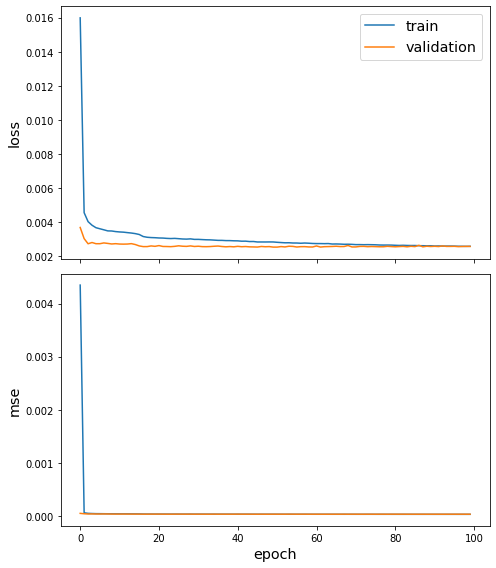

In [22]:
sg.utils.plot_history(history)

## Predictions

In [23]:
# Actual prediction
ythat = model.predict(trainX)
yhat = model.predict(testX)

In [24]:
# We need to rescale the predictions because we applied normalization in the first place
## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()

## actual train and test values
train_rescref = np.array(trainY * max_speed)
test_rescref = np.array(testY * max_speed)

In [25]:
## Rescale model predicted values
train_rescpred = np.array((ythat) * max_speed)
test_rescpred = np.array((yhat) * max_speed)

## Evaluating Performance

In [26]:
# Measuring Performance
## Naive prediction benchmark (using previous observed value)

testnpred = np.array(testX)[
    :, :, -1
]  # picking the last speed of the 10 sequence for each segment in each sample
testnpredc = (testnpred) * max_speed

In [27]:
## Performance measures

seg_mael = []
seg_masel = []
seg_nmael = []

for j in range(testX.shape[-1]):

    seg_mael.append(
        np.mean(np.abs(test_rescref.T[j] - test_rescpred.T[j]))
    )  # Mean Absolute Error for NN
    seg_nmael.append(
        np.mean(np.abs(test_rescref.T[j] - testnpredc.T[j]))
    )  # Mean Absolute Error for naive prediction
    if seg_nmael[-1] != 0:
        seg_masel.append(
            seg_mael[-1] / seg_nmael[-1]
        )  # Ratio of the two: Mean Absolute Scaled Error
    else:
        seg_masel.append(np.NaN)

print("Total (ave) MAE for NN: " + str(np.mean(np.array(seg_mael))))
print("Total (ave) MAE for naive prediction: " + str(np.mean(np.array(seg_nmael))))
print(
    "Total (ave) MASE for per-segment NN/naive MAE: "
    + str(np.nanmean(np.array(seg_masel)))
)
print(
    "...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction."
)

Total (ave) MAE for NN: 13.868226897524764
Total (ave) MAE for naive prediction: 16.393259601922107
Total (ave) MASE for per-segment NN/naive MAE: 0.8611508426924761
...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction.


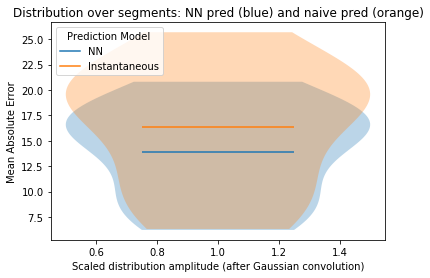

In [28]:
# plot violin plot of MAE for naive and NN predictions
fig, ax = plt.subplots()
# xl = minsl

ax.violinplot(
    list(seg_mael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

ax.violinplot(
    list(seg_nmael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

line1 = mlines.Line2D([], [], label="NN")
line2 = mlines.Line2D([], [], color="C1", label="Instantaneous")

ax.set_xlabel("Scaled distribution amplitude (after Gaussian convolution)")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Distribution over segments: NN pred (blue) and naive pred (orange)")
plt.legend(handles=(line1, line2), title="Prediction Model", loc=2)
plt.show()

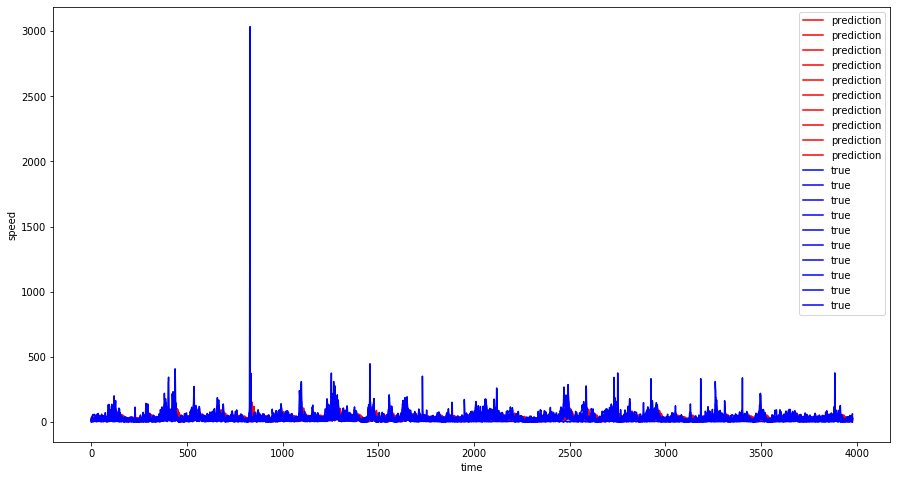

In [31]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred
a_true = test_rescref
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()